In [1]:
#### LIBRARIES AND FUNCTIONS
using Plots
using JLD2
using Statistics
using Random
using LinearAlgebra
using StatsBase
using Integrals
using GenericSchur
using Interpolations
using FiniteDifferences
using LaTeXStrings

function Expanding_Map_Integrate(x0,p)
    a,b,c,σ,tr,M = p
    x = zeros(M+tr)
    xOld = x0;
    for i in 1:M+tr
        x[i] = mod( a*xOld - b*sin(6*xOld) + c*cos(3*xOld) + σ*randn() , 2*π)
        xOld = x[i]
    end
    return x[1+tr:end]
end

function Fourier_Dictionary(x,K_vectors)
    transpose( exp.(1im*K_vectors *x ) )/ sqrt(2*π)
end

function Poly_Dictionary(x,order)
    powers = 0:order
    transpose(x.^powers)
end

function Ulam_Dictionary(x,xgrid)
    y = zeros(length(xgrid))

    ii = findfirst(y -> y<=0, x .- xgrid )
    if(ii>1)
        y[ii-1] = 1
    else 
        y[1] = 1
    end
    return transpose(y)
end

function eDMD(x,Dictionary)
    trial = Dictionary(x[1]);

    A = zeros(size(trial)[2],size(trial)[2])
    G = zeros(size(trial)[2],size(trial)[2])
    B = zeros(size(trial)[2],size(trial)[2])

    l = size(x)[1] - 1

    for i in 1:l

        Ψx = Dictionary(x[i]) 
        Ψy = Dictionary(x[i+1])   
        
        G = G + Ψx'*Ψx  ./l
        A = A + Ψx'*Ψy  ./l
        B = B + Ψy'*Ψy  ./l
    end

    K = pinv(G)*A;
    return G,A,B,K
end

function spect_properties(K)

    S = schur(K);
    λ = S.values;
    Ξ = eigvecs(S);
    W = eigvecs(S,left=true);
    r = sortperm(λ,by=abs,rev=true) ; 
    
    λ = λ[r]; Ξ = Ξ[:,r]; W = W[:,r];
    normalisation = diag( W'*Ξ )
    L = W'; 
    for i in 1:size(L)[2]
         L[i,:] = L[i,:] / normalisation[i]
    end
    W = L';
    return λ,Ξ,W

end

function proj_dictionary_analytical(obs,dict)
    f(u, p) = obs(u)* conj( dict(u) )
    domain = (0,2*pi) # (lb, ub)
    prob = IntegralProblem(f, domain)
    sol = solve(prob, HCubatureJL(); reltol = 1e-3, abstol = 1e-3)
    return transpose(sol.u);
end

function proj_dictionary_numerical(obs,dict,xgrid)
    dict_num = stack( transpose( dict.(xgrid) ),dims=1)
    h_num = zeros(ComplexF64,length(F_dict(0)),1);
    for i in 1:length(h_num)
        y = conj( dict_num[:,i] )
        problem = SampledIntegralProblem(y.*obs, xgrid)
        method = SimpsonsRule()
        h_num[i,1] = solve(problem, method).u
    end
    return h_num
end

function Spectral_Corr(v1,v2,λ,Δ,t)
    sum = zeros(ComplexF64,1); 
    for k in 2:length(v1)
        for l in 2:length(v2)
            sum[1] = sum[1] + v1[k]*λ[k].^t*conj(v2[l])*Δ[k,l]
        end
    end
    return sum[1]
end

function reconstruct(dict,coeff,xgrid)
    return stack( transpose( dict.(xgrid) ),dims=1)*coeff
end

function get_residual(λ,ξ,G,A,B)
    N = size(G)[1]
    num = 0 ; den = 0
    for k in 1:N
        for l in 1:N
            num +=  conj(ξ[k])*ξ[l] * (B[k,l] - λ *conj(A[l,k]) - conj(λ)*A[k,l] + abs(λ)^2*G[k,l] )
            den += conj(ξ[k])*ξ[l]*G[k,l]
        end
    end
    return sqrt(num / den) 
end

get_residual (generic function with 1 method)

In [2]:
# Parameters of the map
a = 3; b = 0.4 ; c = 0.08; σ = 0
tr = 200 # Transient to remove
M = 5*10^5 # Length of trajectory
x0 = 2*pi*rand() # Initial condition
p = (a,b,c,σ,tr,M) 
x = Expanding_Map_Integrate(x0,p);

In [4]:
# Fourier Dictionary specifications
K_max = 30 
K_vectors = - K_max : K_max 
# Polynomial Dictionary specifications
order = 10
# Ulam Dictionary specifications
xmin = 0; xmax = 2*π; Δx= 0.03
xgrid = collect( range( start=xmin,stop=2*π+Δx ,step=Δx) )

F_dict(x) = Fourier_Dictionary(x,K_vectors) 
Poly_dict(x) = Poly_Dictionary(x,order)
Ulam_dict(x) = Ulam_Dictionary(x,xgrid)

Ulam_dict (generic function with 1 method)

In [5]:
G,A,B,K = eDMD(x,F_dict); 
#GPoly, K_Poly = eDMD((x.-mean(x))./std(x),Poly_dict); 
#K_Ulam = eDMD(x,Ulam_dict);

(ComplexF64[0.15915494309103762 + 0.0im 5.044258458535134e-5 + 0.03760826540718534im … 0.0001573573088400899 - 0.00021276578606942373im 6.090658511975463e-5 + 8.685899442459851e-5im; 5.044258458535134e-5 - 0.03760826540718534im 0.15915494309103762 + 0.0im … 7.715211948868205e-5 + 3.52823519868185e-5im 0.00015735730884009264 - 0.0002127657860694197im; … ; 0.0001573573088400899 + 0.00021276578606942373im 7.715211948868205e-5 - 3.52823519868185e-5im … 0.15915494309103762 + 0.0im 5.044258458534393e-5 + 0.03760826540718527im; 6.090658511975463e-5 - 8.685899442459851e-5im 0.00015735730884009264 + 0.0002127657860694197im … 5.044258458534393e-5 - 0.03760826540718527im 0.15915494309103762 + 0.0im], ComplexF64[-0.033173005329407826 - 6.220024991394152e-5im -8.599911851149519e-5 - 0.05427614075925936im … -3.302796570259332e-5 + 0.0004837614192660336im 0.00017714967158877142 + 0.00023210566244672115im; -0.00018661419894332905 - 0.02637712990442688im -0.021766000419310486 - 0.00014869330232896317im

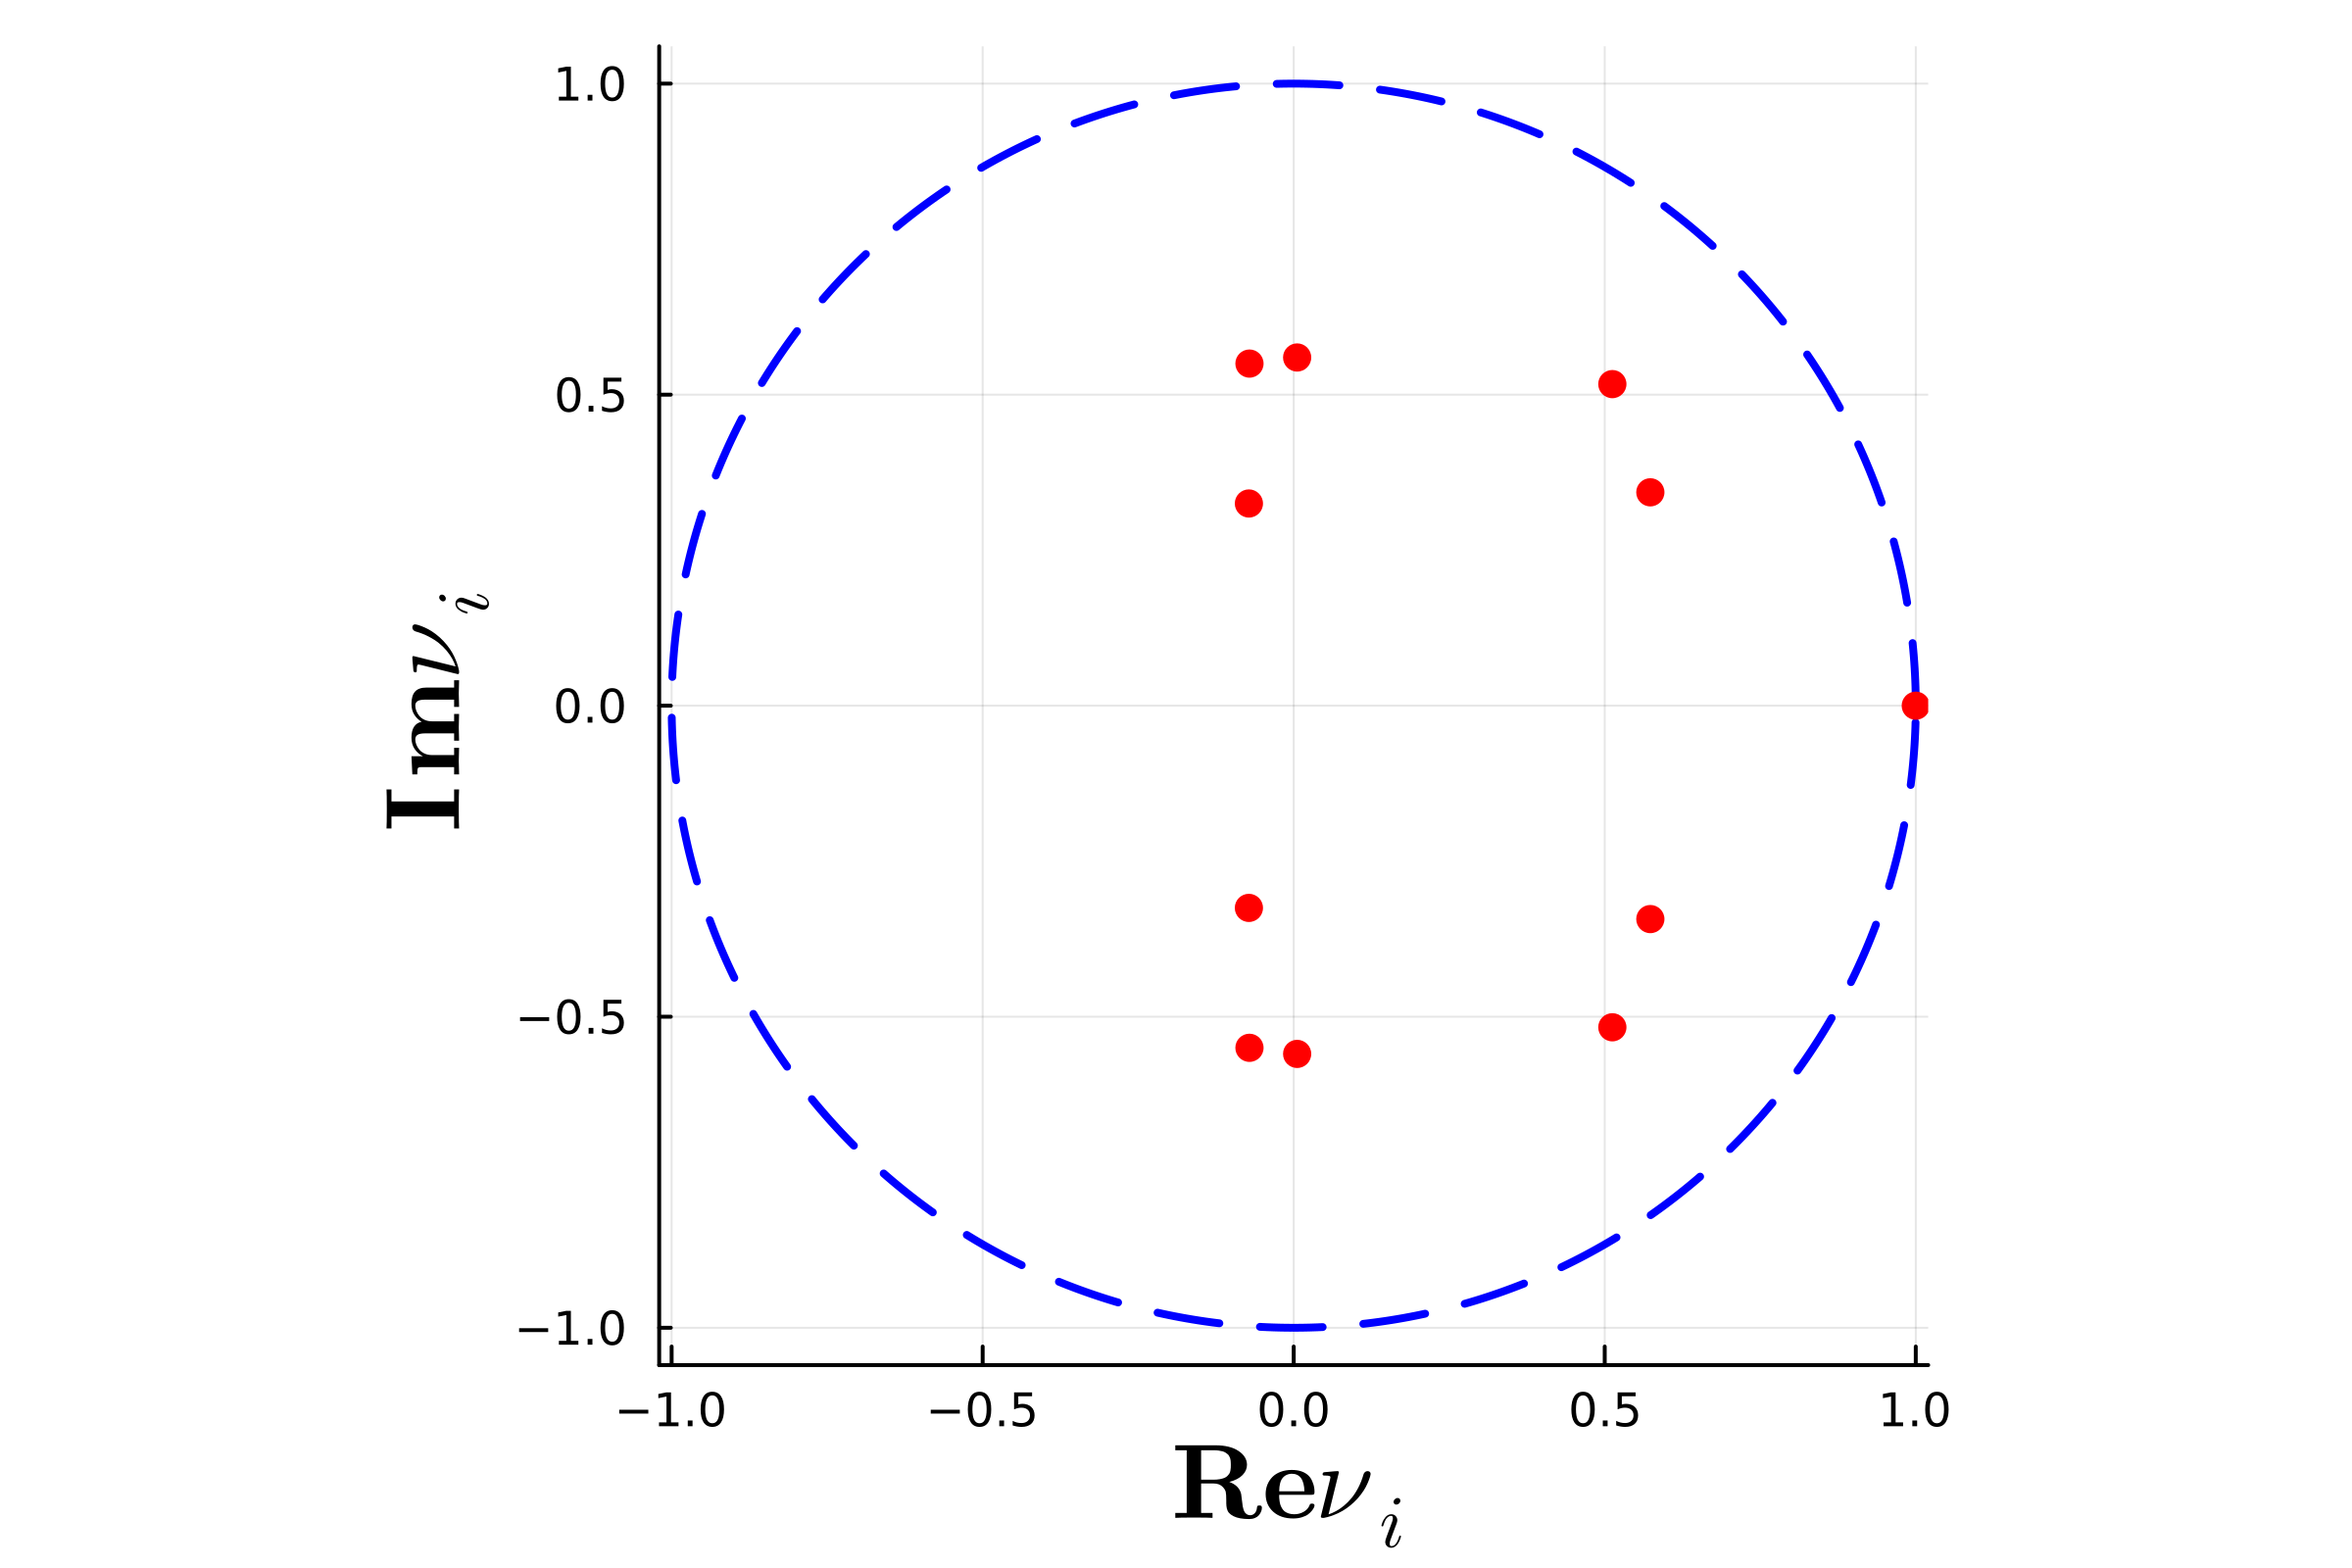

In [6]:
#λpoly,Ξpoly,Wpoly = spect_properties(K_Poly);
#λUlam,ΞUlam,WUlam = spect_properties(K_Ulam);
λ,Ξ,W = spect_properties(K);
Δ = transpose( Ξ'*G*Ξ );
to_show = 1:21
thetas = 0:0.01:2*π
plot(cos.(thetas),sin.(thetas),color=:blue,label="",linestyle=:dash,linewidth=2,aspect_ratio = :equal,dpi=400)
scatter!(real(λ[to_show]),imag(λ[to_show]),markershape=:circle,label="",markersize=4,markerstrokewidth=0,color=:red)
#scatter!(real(λpoly),imag(λpoly),markershape=:circle,aspect_ratio = :equal,label="Poly",color=:red,markersize=3,markerstrokewidth=0 )
#scatter!(real(λUlam),imag(λUlam),markershape=:circle,aspect_ratio = :equal,label="Ulam",color=:green,markersize=3,markerstrokewidth=0 )

xlims!(-1.02,1.02)
xlabel!(L"\mathbf{Re}{\nu}_i",xguidefontsize=18)
ylabel!(L"\mathbf{Im}{\nu}_i",yguidefontsize=18)


### Plotting the first eigenfunctions

In [ ]:
xgrid = 0:0.001:2*pi;
selected = [1,2,4,6]
Φ_global = [ [F_dict(y)*Ξ[:,i] for y in xgrid] for i in selected]  ;
A = plot(xgrid,real.(Φ_global[1]),label="")
for i in 1:length(selected)
    plot!(xgrid,real.(Φ_global[i]),label="")
end

B = plot(xgrid,imag.(Φ_global[1]),label="")
for i in 1:length(selected)
    plot!(xgrid,imag.(Φ_global[i]),label="")
end

plot(A,B,layout= @layout [a;b])

In [ ]:
A = nothing ; B = nothing; Φ_global = nothing ;GC.gc()

### Correlation functions: decay of the modes and any observable

In [7]:
x0 = 2*pi*rand()
x = Expanding_Map_Integrate(x0,p);

selected = [2,4,6,8]
Φ_traj = [ [F_dict(y)*Ξ[:,i] for y in x] for i in selected];

In [8]:
cf = [autocov(real.(Φ_traj[i]);demean=true) + autocov(imag.(Φ_traj[i]);demean=true)  for i in 1:length(selected)]

4-element Vector{Vector{Float64}}:
 [0.11473440733539783, 0.05864010741014555, -0.0002997390402288806, -0.031554311776188435, -0.033254907544969646, -0.01592754698709736, 0.0011406303003876292, 0.009457456089239414, 0.008961739795797006, 0.004058386880681277  …  0.0005054415202794152, 0.00045869602675386917, 0.00023997555476158505, -0.00023228266342495792, -0.0006139641809519259, -0.0006208381862515308, -0.00030435917620590526, 0.0001414183697393157, 0.0005651186226679972, 0.0006132701307383517]
 [0.10649049676855485, 0.06090022535361589, 0.02247413307760584, -0.0012451455542076052, -0.012958371548532535, -0.012825451598847412, -0.009176573974173867, -0.004807680859366215, -0.001481479906754982, 0.000515302009738342  …  -0.00011853179777720021, -0.00013644158386993466, -0.00017109496723156524, -0.0001958699980011273, -6.044981340325301e-5, 0.0001798199352715079, 0.0002712277017402248, 0.0003130608902820502, 0.00012012232034092388, -0.00020973233026645374]
 [0.10075203879580133, 0.00052

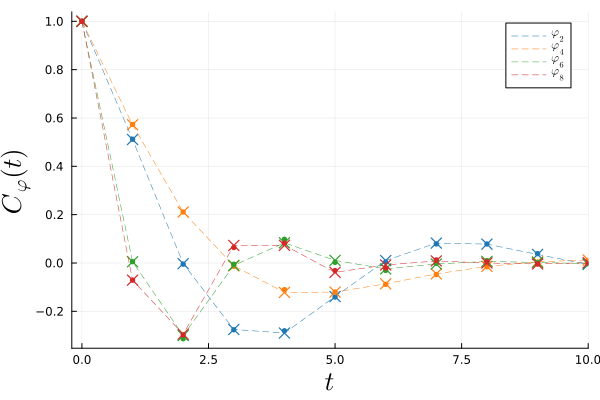

In [9]:
cf = [autocov(real.(Φ_traj[i]);demean=true) + autocov(imag.(Φ_traj[i]);demean=true)  for i in 1:length(selected)]
n_time =  collect(0:length(cf[1])-1)
Aplot = plot()
colors = palette(:tab10)
for (i,value) in enumerate(selected)
    plot!(n_time,cf[i]/cf[i][1],label= L"\varphi_{%$ value}",color=colors[i],linewidth=0.5,linestyle=:dash) 
    scatter!(n_time,cf[i]/cf[i][1],label= "",color=colors[i],
    markerstrokewidth=1.5,markershape=:x,markersize=5.5) 
    scatter!(n_time,real( λ[value].^(n_time)),markershape=:circle,markersize=3,markerstrokewidth=0,color=colors[i],label="")
    
end
xlabel!(L"t",xguidefontsize=18)
ylabel!(L"C_{\varphi}(t)",yguidefontsize=18)
xlims!(-0.2,10)

In [ ]:
### Plotting a few correlation functions

cf = [autocov(real.(Φ_traj[i]);demean=true) + autocov(imag.(Φ_traj[i]);demean=true)  for i in 1:length(selected)]
n_time =  collect(0:length(cf[1])-1)
Aplot = plot()
colors = palette(:tab10)
for (i,value) in enumerate(selected)
    plot!(n_time,cf[i]/cf[i][1],color=colors[i],linewidth=0.8,label=L"\varphi_{%$ value}",linestyle=:dash) 
    scatter!(n_time,cf[i]/cf[i][1],color=colors[i],
    markerstrokewidth=1.5,markershape=:x,markersize=5.5,label= "") 
    scatter!(n_time,real( λ[value].^(n_time)),markershape=:circle,markersize=3
    ,markerstrokewidth=0,color=colors[i],label="")
end
xlabel!(L"t",xguidefontsize=18)
ylabel!(L"C_{\varphi}(t)",yguidefontsize=18)
xlims!(-0.2,10.5)
xticks!(0:2:10)

# A few correlations
obs(u) = u#sin.(u).^2
h = proj_dictionary_analytical(obs,F_dict);
v = W'*h;
S(t) = Spectral_Corr(v,v,λ,Δ,t)
cf = autocor(obs.(x);demean=true)
A1plot = plot()
plot!(0:length(cf)-1,cf,color=colors[1],linewidth=0.8,label=L"f=x",linestyle=:dash)
scatter!(0:length(cf)-1,cf,color=colors[1],markerstrokewidth=1.5,markershape=:x,markersize=5.5,label="")
s = real( S.(n_time) )
scatter!(n_time,s/s[1],color=colors[1],markersize=3.5,markerstrokewidth=0,label="")

obs(u) = sin.(u).^2
h = proj_dictionary_analytical(obs,F_dict);
v = W'*h;
S(t) = Spectral_Corr(v,v,λ,Δ,t)
cf = autocor(obs.(x);demean=true)
s = real( S.(n_time) )
plot!(0:length(cf)-1,cf,color=colors[2],linewidth=0.8,label=L"f=\sin^2(x)",linestyle=:dash)
scatter!(0:length(cf)-1,cf,color=colors[2],markerstrokewidth=1.5,markershape=:x,markersize=5.5,label="")
scatter!(n_time,s/s[1],color=colors[2],markersize=3.5,markerstrokewidth=0,label="")

obs(u) =  abs.( log(u+0.1) )
h = proj_dictionary_analytical(obs,F_dict);
v = W'*h;
S(t) = Spectral_Corr(v,v,λ,Δ,t)
cf = autocor(obs.(x);demean=true)
s = real( S.(n_time) )
plot!(0:length(cf)-1,cf,color=colors[3],linewidth=0.5,label=L"f =| \log(x+\delta) |",linestyle=:dash)
scatter!(0:length(cf)-1,cf,color=colors[3],markerstrokewidth=1.5,markershape=:x,markersize=5.5,label="")
scatter!(n_time,s/s[1],color=colors[3],markersize=3.5,markerstrokewidth=0,label="")

xlabel!(L"t",xguidefontsize=18)
ylabel!(L"C_{f}(t)",yguidefontsize=18)
xlims!(-0.2,10.5)
xticks!(0:2:10)
# A few correlations
obs1(u) = u
obs2(u) = abs.(log.(u+0.1))#cos.(u).^2
h1 = proj_dictionary_analytical(obs1,F_dict);
h2 = proj_dictionary_analytical(obs2,F_dict);
v1 = W'*h1;
v2 = W'*h2;
S(t) = Spectral_Corr(v1,v2,λ,Δ,t)
cf = crosscov(obs2.(x),obs1.(x),n_time;demean=true)
B = plot()
plot!(n_time,cf/cf[1],color=colors[1],linewidth=0.8,label=L"f=x, g= |\ln(x+\delta)|",linestyle=:dash)
scatter!(0:length(cf)-1,cf/cf[1],color=colors[1],markerstrokewidth=1.5,markershape=:x,markersize=5.5,label="")
s = real( S.(n_time) )
scatter!(n_time,s/s[1],color=colors[1],markersize=3.5,markerstrokewidth=0,label="")
xlims!(-0.2,12)


obs1(u) = sin.(u)
obs2(u) = cos.(u).^2
h1 = proj_dictionary_analytical(obs1,F_dict);
h2 = proj_dictionary_analytical(obs2,F_dict);
v1 = W'*h1;
v2 = W'*h2;
S(t) = Spectral_Corr(v1,v2,λ,Δ,t)
#B1 = plot()
cf = crosscov(obs2.(x),obs1.(x),n_time ;demean=true)
plot!(n_time,cf/abs(cf[1]),color=colors[2],linewidth=0.5,label=L"f=\sin(x), g = \cos^2(x)",linestyle=:dash)
scatter!(0:length(cf)-1,cf/abs(cf[1]),color=colors[2],markerstrokewidth=1.5,markershape=:x,markersize=5.5,label="")
s = real( S.(n_time) )
scatter!(n_time,s/abs(s[1]),color=colors[2],markersize=3.5,markerstrokewidth=0,label="")
xlims!(-0.2,15)
xlabel!(L"t",xguidefontsize=18)
ylabel!(L"C_{f,g}(t)",yguidefontsize=18)

l = @layout [
   a ; b  c
]

plot(Aplot,A1plot,B,layout=l,dpi=600)
#savefig("Correlation_functions.png")

In [63]:
Aplot = nothing; A1plot = nothing; B = nothing; Φ_traj = nothing; 
GC.gc()

### Linear Response

In [34]:
# Get the invariant measure
edges = 0:2*π/1000:2*π ; dx = (edges[2] - edges[1])
xp = edges[1] + dx/2 : dx : edges[end]
H = fit(Histogram,x,edges,closed=:left)
H = normalize(H,mode=:pdf);
ρ0 = H.weights
# Decompose the log into the dictionary
g = log.(ρ0)
gk = proj_dictionary_numerical(g,F_dict,xp)
Ik = 1im .*  gk .* K_vectors ; I = reconstruct(F_dict,Ik,xp);
# Get decomposition of log into the K-eigenfunctions
vI = W'*Ik;

In [ ]:
obs1(u) = cos.(u); h1 = proj_dictionary_analytical(obs1,F_dict); v1 = W'*h1
obs2(u) = cos.(2*u); h2 = proj_dictionary_analytical(obs2,F_dict); v2 = W'*h2;
G1(t) = - Spectral_Corr(v1,vI,λ,Δ,t)
G2(t) = - Spectral_Corr(v2,vI,λ,Δ,t)

In [43]:
function return_obs(x)
    return [ cos(x) , cos(2*x), cos(3*x) , cos(4*x), cos(5*x),
             sin(x), sin(2*x), sin(3*x),sin(4*x),sin(5*x), 
             1.0 ./(2+sin(2*x)) , cos(atan(3*sin(x)))/sin(atan(3)), atan(20*sin(2*x))/ atan(20), (1/2+1/2*sin(2*x)) ./ (2+cos(10*x)), (x-pi) .^2
    ] 
end
X = JLD2.load("Data_GreenFunctions.jld2")
Data = X["Data"];

In [45]:
# Matrix with all the projections
l2 = length(return_obs(1)); n_time = 1:25;
G_spect = zeros(length(n_time),l2)
for i in 1:l2
    f(x) = return_obs(x)[i]
    v = W'*proj_dictionary_analytical(f,F_dict)
    g_spect(t) = - Spectral_Corr(v,vI,λ,Δ,t)
    G_spect[:,i] = real(g_spect.(n_time))
end

# Compute the experimental Green's function averaging over different amplitudes
L = length(Data[1][:,1])
G = zeros(L,l2)
 for i in 1:length(Data[1:end])
    for ii in 1:l2
        gg = Data[i][:,ii]
        G[:,ii] = G[:,ii] .+ gg ./length(Data[1:end]) 
    end
end

In [ ]:
a = plot(1:L,G[:,1:5],label="",linewidth=0.5,xlabel=["" "" "" "" L"t"],linestyle=:dash,xguidefontsize=18,color=:blue,layout=@layout grid(5,1))
scatter!(1:L,G[:,1:5],label="",markersize=3.5,marker=:x,color=:blue,layout=@layout grid(5,1))
scatter!(n_time,G_spect[:,1:5],label="",markersize=2.5,markerstrokewidth=0,color=:red,layout=@layout grid(5,1))
b = plot(1:L,G[:,6:10],label="",linewidth=0.5,xlabel=["" "" "" "" L"t"],linestyle=:dash,xguidefontsize=18,color=:blue,layout=@layout grid(5,1))
scatter!(1:L,G[:,6:10],label="",markersize=3.5,marker=:x,color=:blue,layout=@layout grid(5,1))
scatter!(n_time,G_spect[:,6:10],label="",markersize=2.5,markerstrokewidth=0,color=:red,layout=@layout grid(5,1))
plot!(a[1],title=L"G_{\cos(kx)}(t)")
plot!(b[1],title=L"G_{\sin(kx)}(t)")
plot(a,b,dpi=600)
xlims!(0.5,15)
ylims!(-2.5,0.9)
yticks!([-2,0])

#savefig("GreensFunctions_BasisFunctions.png")

In [ ]:
# a = plot(1:L,G[:,11:15],label="",linewidth=1.5,xlabel=["" "" "" "" L"t"],xguidefontsize=18,layout=@layout grid(5,1))
# scatter!(n_time,G_spect[:,11:15],label="",markersize=2.5,markerstrokewidth=0,color=:red,layout=@layout grid(5,1))
# xlims!(0.5,15)
# #ylims!(-2.5,0.9)
#yticks!([-2,-1,0], ["-2", "-1", "0"])

a = plot(1:L,G[:,11],label="",linewidth=0.5,color=:blue,linestyle= :dash)
scatter!(1:L,G[:,11],label="",marker=:x,color=:blue,markersize=3.5)
scatter!(n_time,G_spect[:,11],label="",markersize=2.5,markerstrokewidth=0,color=:red)
ylims!(-0.3,0.5)
yticks!([-0.3,0,0.3])

b = plot(1:L,G[:,12],label="",linewidth=0.5,color=:blue,linestyle= :dash)
scatter!(1:L,G[:,12],label="",marker=:x,color=:blue,markersize=3.5)
scatter!(n_time,G_spect[:,12],label="",markersize=2.5,markerstrokewidth=0,color=:red)
ylims!(-0.5,0.5)
yticks!([-0.5,0,0.5],["-0.5", "0","0.5"])

c = plot(1:L,G[:,13],label="",linewidth=0.5,color=:blue,linestyle= :dash)
scatter!(1:L,G[:,13],label="",marker=:x,color=:blue,markersize=3.5)
scatter!(n_time,G_spect[:,13],label="",markersize=2.5,markerstrokewidth=0,color=:red)
ylims!(-2.5,0.5)
yticks!([-2,-1,0],["-2", "-1","0"])

d = plot(1:L,G[:,14],label="",linewidth=0.5,color=:blue,linestyle= :dash)
scatter!(1:L,G[:,14],label="",marker=:x,color=:blue,markersize=3.5)
scatter!(n_time,G_spect[:,14],label="",markersize=2.5,markerstrokewidth=0,color=:red)
ylims!(-0.5,0.5)
yticks!([-0.5,0,0.5],["-0.5", "0","0.5"])

e = plot(1:L,G[:,15],label="",linewidth=0.5,color=:blue,linestyle= :dash)
scatter!(1:L,G[:,15],label="",marker=:x,color=:blue,markersize=3.5)
scatter!(n_time,G_spect[:,15],label="",markersize=2.5,markerstrokewidth=0,color=:red)
ylims!(-10.5,2.5)
yticks!([-8,-4,0])
xlabel!(L"t",xguidefontsize=18)


A = plot(a,b,c,d,e,layout= @layout grid(5,1))
xlims!(0.8,15.5)
xticks!(1:2:15)
plot!(A[1],title=L"G_{f}(t)")

xgrid = 0:0.001:2*π;
numObs = stack( return_obs.(xgrid) ,dims=1);
B = plot(xgrid,numObs[:,11:15],label="",xlabel=["" "" "" "" L"x"],xguidefontsize=18,linewidth=1.5,
layout=@layout grid(5,1))
plot!(B[1],yticks=[0,0.5,1],ylims=[0,1.2],title=L"f(x)") 
plot!(B[2],yticks=[0,0.5,1],ylims=[0,1.2]) 
plot!(B[3],yticks=[-1,0,1],ylims=[-1.2,1.2]) 
plot!(B[4],yticks=[0,0.5,1],ylims=[-0.1,1.2]) 
plot!(B[5],yticks=[0,5,10],ylims=[-0.5,10.2]) 
plot(B,A,dpi=600)

#savefig("GreensFunctions_Observables.png")

In [ ]:
plot(xp,ρ0,label="",linewidth=1.5,dpi=400)
xlabel!(L"x",xguidefontsize=18)
ylabel!(L"\rho_0(x)",yguidefontsize=18)
#savefig("Invariant_Measure_1d.png")

### Robustness to different hyper-parameters
First with respect to the number of wave vectors

In [46]:
#We fix observable
f(x) = (x - π).^2
# Take the numerical Green's function
GreenFunct = G[:,15];

In [37]:
# Parameters of the map
a = 3; b = 0.4 ; c = 0.08; σ = 0
tr = 200 # Transient to remove
M = 6*10^5 # Length of trajectory
p = (a,b,c,σ,tr,M) 

# Let's cycle over different values of length of dictionary
wave_vectors = 10:5:30
data = Array{Vector{Float64}}(undef, length(wave_vectors))
data2 = Array{Vector{Float64}}(undef, length(wave_vectors))
time = 1:50
n_simulations = 1:1
for (index,K_max) in enumerate( wave_vectors )
    K_vectors = - K_max : K_max 
    F_dict(x) = Fourier_Dictionary(x,K_vectors)

    for n in n_simulations
        # Integrate Dynamical system and get the invariant measure
        x0 = 2*pi*rand() # Initial condition
        x = Expanding_Map_Integrate(x0,p);
        #We get the invariant measure from this long trajectory
        edges = 0:2*π/1000:2*π ; dx = (edges[2] - edges[1])
        xp = edges[1] + dx/2 : dx : edges[end]
        H = fit(Histogram,x,edges,closed=:left)
        H = normalize(H,mode=:pdf);
        ρ0 = H.weights;
        g = log.(ρ0);


        G,K = eDMD(x,F_dict); 
        λ,Ξ,W = spect_properties(K);
        Δ = transpose( Ξ'*G*Ξ );
        
        # Projection of the observable under investigation
        v = W'*proj_dictionary_analytical(f,F_dict)
        # Projection of log into the K-eigenfunctions
        gk = proj_dictionary_numerical(g,F_dict,xp)
        Ik = 1im .*  gk .* K_vectors ; 
        vI = W'*Ik;

        # Spectrally reconstruct
        g_spect(t) = - Spectral_Corr(v,vI,λ,Δ,t)
        if(n == 1)
            data[index] =  real( g_spect.(time) )    / length(n_simulations)
            data2[index] = real( g_spect.(time) ).^2 / length(n_simulations)
        else
            data[index]  .+= real( g_spect.(time) )    / length(n_simulations)
            data2[index] .+= real( g_spect.(time) ).^2 / length(n_simulations)
        end
    end
end

In [ ]:
length(data)

In [42]:
# Let's cycle over different values of the length of traj
a = 3; b = 0.4 ; c = 0.08; σ = 0
tr = 200 # Transient to remove
Ms = [2000,4000,8000,16000]
K_max = 30
time = 1:50
n_simulations = 1:100

K_vectors = - K_max : K_max 
F_dict(x) = Fourier_Dictionary(x,K_vectors)


DataBis = Array{Vector{Float64}}(undef, length(Ms))
DataBis2 = Array{Vector{Float64}}(undef, length(Ms))
DataTris = Array{Vector{Float64}}(undef, length(Ms))
DataTris2 = Array{Vector{Float64}}(undef, length(Ms))


# Long Simulation
M = 6*10^5 # Length of trajectory
p = (a,b,c,σ,tr,M) 
# Integrate Dynamical system and get the invariant measure
x0 = 2*pi*rand() # Initial condition
x = Expanding_Map_Integrate(x0,p);
#We get the invariant measure from this long trajectory
edges = 0:2*π/1000:2*π ; dx = (edges[2] - edges[1])
xpLong = edges[1] + dx/2 : dx : edges[end]
H = fit(Histogram,x,edges,closed=:left)
H = normalize(H,mode=:pdf);
ρ0 = H.weights;
gLong = log.(ρ0);

for (index,m) in enumerate( Ms )
    # Variable length
    p = (a,b,c,σ,tr,m) 
    
    for n in n_simulations

        # Integrate Dynamical system and get the invariant measure
        x0 = 2*pi*rand() # Initial condition
        x = Expanding_Map_Integrate(x0,p);
        #We get the invariant measure from this long trajectory
        edges = 0:0.01:2*π ; dx = (edges[2] - edges[1])
        xp = edges[1] + dx/2 : dx : edges[end]
        H = fit(Histogram,x,edges,closed=:left)
        H = normalize(H,mode=:pdf);
        ρ0 = H.weights;
        g = log.(ρ0);
        g[isinf.(g)] .= -5


        G,K = eDMD(x,F_dict); 
        λ,Ξ,W = spect_properties(K);
        Δ = transpose( Ξ'*G*Ξ );
        
        # Projection of the observable under investigation
        v = W'*proj_dictionary_analytical(f,F_dict)
        # Projection of log into the K-eigenfunctions
        gk = proj_dictionary_numerical(g,F_dict,xp)
        Ik = 1im .*  gk .* K_vectors ; 
        vI = W'*Ik;
        
        gkLong = proj_dictionary_numerical(gLong,F_dict,xpLong)
        IkLong = 1im .*  gkLong .* K_vectors ; 
        vILong = W'*IkLong;

        # Spectrally reconstruct
        g_spect(t) = - Spectral_Corr(v,vI,λ,Δ,t)
        g_spectLong(t) = - Spectral_Corr(v,vILong,λ,Δ,t)
        if(n == 1)
            DataBis[index] =  real( g_spect.(time) )    / length(n_simulations)
            DataBis2[index] = real( g_spect.(time) ).^2 / length(n_simulations)

            DataTris[index] =  real( g_spectLong.(time) )    / length(n_simulations)
            DataTris2[index] = real( g_spectLong.(time) ).^2 / length(n_simulations)

        else
            DataBis[index]  .+= real( g_spect.(time) )    / length(n_simulations)
            DataBis2[index] .+= real( g_spect.(time) ).^2 / length(n_simulations)

            DataTris[index]  .+=  real( g_spectLong.(time) )    / length(n_simulations)
            DataTris2[index] .+= real( g_spectLong.(time) ).^2 / length(n_simulations)

        end
    end
end

In [ ]:
#plot(real(GreenFunct))
plot(DataBis[1])
plot!(DataTris[1])

In [ ]:
colors = palette(:tab10)
A = plot(1:length(GreenFunct),GreenFunct,color=:blue,linestyle=:dash,label="",linewidth=1.5)
scatter!(A,1:length(GreenFunct),GreenFunct,marker=:x,color=:blue,markersize=7,label="")
for i in 1:length(data)
    k = wave_vectors[i]
    plot!(A,1:length(data[i]),data[i],linestyle=:dash,label=L"K_{max} = %$k",color=colors[i])
    scatter!(A,1:length(data[i]),data[i],linestyle=:dash,label="",
    markerstrokewidth=0,color=colors[i],markersize=3)
end
xlabel!(L"t",xguidefontsize=18)
ylabel!(L"G_f(t)",yguidefontsize=18)
xlims!(0,20)
plot(A,dpi=400)
# savefig("Robustness_K.png")

In [ ]:
colors = palette(:tab10)
B = plot(1:length(GreenFunct),GreenFunct,color=:blue,label="",linewidth=2)
#scatter!(B,1:length(GreenFunct),GreenFunct,marker=:x,color=:blue,markersize=7,label="")
xlims!(0,20)
for i in 1:length(DataBis)
    m = Ms[i]
    plot!(B,1:length(DataBis[i]),DataBis[i],yerr=sqrt.(DataBis2[i] .- DataBis[i].^2),label=L"M = %$m",
    color=colors[i],msc=colors[i])
    scatter!(B,1:length(DataBis[i]),DataBis[i],label="",
    markerstrokewidth=0,color=colors[i],markersize=3)
end
plot(B)

In [ ]:
a1 = plot()
i = 1; m = Ms[i]
plot!(1:length(GreenFunct),GreenFunct,color=:blue,label="",linewidth=1.3,linestyle=:dash)
#scatter!(1:length(GreenFunct),GreenFunct,marker=:x,color=:blue,markersize=5,label="")
plot!(1:length(DataBis[i]),DataBis[i],ribbon=sqrt.(DataBis2[i] .- DataBis[i].^2),
    color=colors[i],msc=colors[i],linestyle=:dash,fillalpha=0.3,label="")
#scatter!(1:length(DataBis[i]),DataBis[i],label="",
#markerstrokewidth=0,color=colors[i],markersize=3)
ylabel!(L"G_f(t)",yguidefontsize=12)

a2 = plot()
i = 2; m = Ms[i]
plot!(1:length(GreenFunct),GreenFunct,color=:blue,label="",linewidth=1.3,linestyle=:dash)
#scatter!(1:length(GreenFunct),GreenFunct,marker=:x,color=:blue,markersize=5,label="")
plot!(1:length(DataBis[i]),DataBis[i],ribbon=sqrt.(DataBis2[i] .- DataBis[i].^2),
    color=colors[i],msc=colors[i],linestyle=:dash,fillalpha=0.4,label="")
#scatter!(1:length(DataBis[i]),DataBis[i],label="",
#markerstrokewidth=0,color=colors[i],markersize=3)
ylabel!(L"G_f(t)",yguidefontsize=12)
a3 = plot()
i = 3; m = Ms[i]
plot!(1:length(GreenFunct),GreenFunct,color=:blue,label="",linewidth=1.3,linestyle=:dash)
#scatter!(1:length(GreenFunct),GreenFunct,marker=:x,color=:blue,markersize=5,label="")
plot!(1:length(DataBis[i]),DataBis[i],ribbon=sqrt.(DataBis2[i] .- DataBis[i].^2),
    color=colors[i],msc=colors[i],linestyle=:dash,fillalpha=0.5,label="")
#scatter!(1:length(DataBis[i]),DataBis[i],label="",
#markerstrokewidth=0,color=colors[i],markersize=3)
ylabel!(L"G_f(t)",yguidefontsize=12)
a4 = plot()
i = 4; m = Ms[i]
plot!(1:length(GreenFunct),GreenFunct,color=:blue,label="",linewidth=1.3,linestyle=:dash)
#scatter!(1:length(GreenFunct),GreenFunct,marker=:x,color=:blue,markersize=5,label="")
plot!(1:length(DataBis[i]),DataBis[i],ribbon=sqrt.(DataBis2[i] .- DataBis[i].^2),
    color=colors[i],msc=colors[i],linestyle=:dash,fillalpha=0.7,label="")
#scatter!(1:length(DataBis[i]),DataBis[i],label="",
#markerstrokewidth=0,color=colors[i],markersize=3)
xlabel!(L"t",xguidefontsize=18)
ylabel!(L"G_f(t)",yguidefontsize=12)
A1 = plot(a1,a2,a3,a4;layout=@layout [a ; b ; c ; d])
xlims!(0,20)
yticks!([-8 , -4  , 0])

b1 = plot()
i = 1; m = Ms[i]
plot!(1:length(GreenFunct),GreenFunct,color=:blue,label="",linewidth=1.3,linestyle=:dash)
plot!(1:length(DataTris[i]),DataTris[i],ribbon=sqrt.(DataTris2[i] .- DataTris[i].^2),
    color=colors[i],msc=colors[i],linestyle=:dash,fillalpha=0.3,label="")



b2 = plot()
i = 2; m = Ms[i]
plot!(1:length(GreenFunct),GreenFunct,color=:blue,label="",linewidth=1.3,linestyle=:dash)
plot!(1:length(DataTris[i]),DataTris[i],ribbon=sqrt.(DataTris2[i] .- DataTris[i].^2),
    color=colors[i],msc=colors[i],linestyle=:dash,fillalpha=0.3,label="")

b3 = plot()
i = 3; m = Ms[i]
plot!(1:length(GreenFunct),GreenFunct,color=:blue,label="",linewidth=1.3,linestyle=:dash)
plot!(1:length(DataTris[i]),DataTris[i],ribbon=sqrt.(DataTris2[i] .- DataTris[i].^2),
    color=colors[i],msc=colors[i],linestyle=:dash,fillalpha=0.3,label="")

b4 = plot()
i = 4; m = Ms[i]
plot!(1:length(GreenFunct),GreenFunct,color=:blue,label="",linewidth=1.3,linestyle=:dash)
plot!(1:length(DataTris[i]),DataTris[i],ribbon=sqrt.(DataTris2[i] .- DataTris[i].^2),
    color=colors[i],msc=colors[i],linestyle=:dash,fillalpha=0.3,label="")
xlabel!(L"t",xguidefontsize=18)
B1 = plot(b1,b2,b3,b4;layout=@layout [a ; b ; c ; d])


plot(A1,B1,dpi=400)
xlims!(0.7,9)
yticks!([-8 , -4  , 0])
xticks!([1,3,5,7,9])
#savefig("Robustness_M.png")